<a href="https://colab.research.google.com/github/anshupandey/Generative-AI-for-Professionals/blob/main/Multimodal_RAG_Chroma_OpenAI" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/ChromaMultiModalDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chroma Multi-Modal Demo with LlamaIndex

>[Chroma](https://docs.trychroma.com/getting-started) is a AI-native open-source vector database focused on developer productivity and happiness. Chroma is licensed under Apache 2.0.


- [Website](https://www.trychroma.com/)
- [Documentation](https://docs.trychroma.com/)
- [Twitter](https://twitter.com/trychroma)
- [Discord](https://discord.gg/MMeYNTmh3x)

Chroma is fully-typed, fully-tested and fully-documented.

Install Chroma with:

```sh
pip install chromadb
```

Chroma runs in various modes. See below for examples of each integrated with LangChain.
- `in-memory` - in a python script or jupyter notebook
- `in-memory with persistance` - in a script or notebook and save/load to disk
- `in a docker container` - as a server running your local machine or in the cloud

Like any other database, you can:
- `.add`
- `.get`
- `.update`
- `.upsert`
- `.delete`
- `.peek`
- and `.query` runs the similarity search.

View full docs at [docs](https://docs.trychroma.com/reference/Collection).

## Basic Example

In this basic example, we take the a Paul Graham essay, split it into chunks, embed it using an open-source embedding model, load it into Chroma, and then query it.

If you're opening this Notebook on colab, you will probably need to install LlamaIndex 🦙.

In [ ]:
%pip -q install llama-index-vector-stores-qdrant
%pip -q install llama-index-embeddings-huggingface
%pip -q install llama-index-vector-stores-chroma
%pip -q install llama-index-embeddings-clip

In [ ]:
!pip -q install llama-index

#### Creating a Chroma Index

In [ ]:
!pip -q install llama-index chromadb --quiet
!pip -q install chromadb==0.4.17
!pip -q install sentence-transformers
!pip -q install pydantic==1.10.11
!pip -q install open-clip-torch

In [1]:
# import
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from IPython.display import Markdown, display
import chromadb

In [2]:
# set up OpenAI
import os
import openai

OPENAI_API_KEY = "sk-proj-9dK0cixfLymIfSlPiylkT3BlbkFJkFTCBIyG6GWcUC8ikoTy"
openai.api_key = OPENAI_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Download Images and Texts from Wikipedia

In [3]:
import requests


def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls

In [16]:
# prompt: write code to delete all files in a folder

import os

def delete_all_files(folder_path):
  """Deletes all files in the specified folder.

  Args:
    folder_path: The path to the folder containing the files to delete.
  """

  # Get a list of all files in the folder.
  files = os.listdir(folder_path)

  # Iterate through the files and delete them.
  for file in files:
    file_path = os.path.join(folder_path, file)
    try:
      os.remove(file_path)
    except:
      print("Couldn't delete ",file_path)
delete_all_files("mixed_wiki")

Couldn't delete  mixed_wiki/.ipynb_checkpoints


In [17]:
from pathlib import Path
import urllib.request

image_uuid = 0
MAX_IMAGES_PER_WIKI = 20

wiki_titles = {
    "The Matrix",
    "Toyota Camry",
    "Burj Khalifa",
    "Dubai",
    "Commonwealth Games",
    "FIFA world cup",

}

data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        # page_py = wikipedia.page(title)
        list_img_urls = get_wikipedia_images(title)
        #print(list_img_urls)

        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".jpeg") or url.endswith(".png"):
                image_uuid += 1
                # image_file_name = title + "_" + url.split("/")[-1]

                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("Error in downloading some images for the page: ")) + title)
        continue
print(f"Downloaded {image_uuid} images so far ")

['https://upload.wikimedia.org/wikipedia/commons/7/71/1936_Toyoda_Model_AA_03.jpg', 'https://upload.wikimedia.org/wikipedia/commons/4/46/1955_Toyopet_Crown_03.jpg', 'https://upload.wikimedia.org/wikipedia/commons/2/27/1987_Toyota_Corolla_%28AE82%29_CS_sedan_%282015-11-11%29_01.jpg', 'https://upload.wikimedia.org/wikipedia/commons/7/72/1994_Toyota_Supra_Sport_Roof_in_Red%2C_front_left.jpg', 'https://upload.wikimedia.org/wikipedia/commons/b/b5/1998_Toyota_Prius_NHW10_Silver_Strara_Metallic_%28front%29.jpg', 'https://upload.wikimedia.org/wikipedia/commons/f/f8/2016_Toyota_Tacoma_TRD_Sport_Access_Cab_3.5L_front_5.14.19.jpg', 'https://upload.wikimedia.org/wikipedia/commons/a/ac/2017_Toyota_C-HR_Excel_HEV_CVT_1.8.jpg', 'https://upload.wikimedia.org/wikipedia/commons/a/ac/2018_Toyota_Camry_%28ASV70R%29_Ascent_sedan_%282018-08-27%29_01.jpg', 'https://upload.wikimedia.org/wikipedia/commons/6/6d/2018_Toyota_Crown_2.0_RS.jpg', 'https://upload.wikimedia.org/wikipedia/commons/4/49/2018_Toyota_Hilux

## Set the embedding model

In [18]:
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
# set defalut text and image embedding functions
embedding_function = OpenCLIPEmbeddingFunction()

## Build Chroma Multi-Modal Index with LlamaIndex

In [20]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext
from chromadb.utils.data_loaders import ImageLoader

image_loader = ImageLoader()

# create client and a new collection
chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection(
    "multimodal_collection2",
    embedding_function=embedding_function,
    data_loader=image_loader,
)


# load documents
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()

# set up ChromaVectorStore and load in data
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

## Retrieve results from Multi-Modal Index

In [26]:
retriever = index.as_retriever(similarity_top_k=50)
retrieval_results = retriever.retrieve("Tell me more about Toyota Cars")

[NodeWithScore(node=TextNode(id_='771d1ccb-66bc-4ace-8d53-3567a8afdac1', embedding=None, metadata={'file_path': '/content/mixed_wiki/Toyota.txt', 'file_name': 'Toyota.txt', 'file_type': 'text/plain', 'file_size': 70667, 'creation_date': '2024-04-24', 'last_modified_date': '2024-04-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='deb01996-7ec8-4a09-8815-b8498f66feeb', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/content/mixed_wiki/Toyota.txt', 'file_name': 'Toyota.txt', 'file_type': 'text/plain', 'file_size': 70667, 'creation_date': '2024-04-24', 'last_modified_date': '2024-04-24'}, hash='ae33580831d4fd65d0f222a0f9424607b3ec56ea97f9fff7e5f0c7769c738d2c'), <NodeRelationship.PREVIOUS: '2

**Node ID:** 771d1ccb-66bc-4ace-8d53-3567a8afdac1<br>**Similarity:** 0.7571551474718995<br>**Text:** === 1990s ===

In the 1990s, Toyota began to branch out from producing mostly compact cars by add...<br>

**Node ID:** 7a2ea9f3-1265-44a9-a842-4f925892ac74<br>**Similarity:** 0.7435799748112674<br>**Text:** === SUVs and crossovers ===

Toyota SUV and crossover line-up grew quickly in the late 2010s to 2...<br>

**Node ID:** f275be10-4170-4c02-9613-54e31dcc27ef<br>**Similarity:** 0.7393940876417819<br>**Text:** === 2000s ===

In August 2000, exports began of the Prius. In 2001, Toyota acquired its long time...<br>

**Node ID:** 25bf9d76-b1d4-44ef-bb50-04549728802a<br>**Similarity:** 0.7389028776755933<br>**Text:** === 2010s ===
In 2011, Toyota, along with large parts of the Japanese automotive industry, suffer...<br>

**Node ID:** e973cd85-6168-48af-a414-949d85c69544<br>**Similarity:** 0.7386266095541466<br>**Text:** Toyota Motor Corporation (Japanese: トヨタ自動車株式会社, Hepburn: Toyota Jidōsha kabushikigaisha, IPA: [to...<br>

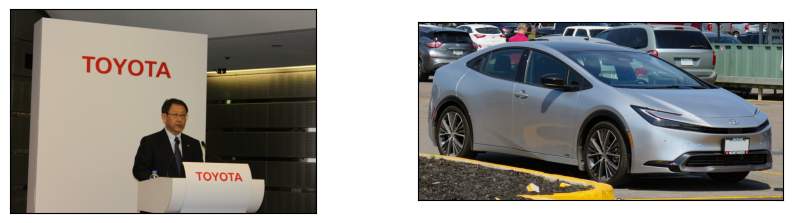

In [27]:
print(retrieval_results)
from llama_index.core.schema import ImageNode
from llama_index.core.response.notebook_utils import (
    display_source_node,
    display_image_uris,
)


image_results = []
MAX_RES = 5
cnt = 0
for r in retrieval_results:
    if isinstance(r.node, ImageNode):
        image_results.append(r.node.metadata["file_path"])
    else:
        if cnt < MAX_RES:
            display_source_node(r)
        cnt += 1

display_image_uris(image_results, [3, 3], top_k=2)